# Imports libraries and Model Class same as trained model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

RobustCNN Model

In [3]:
class RobustCNN(nn.Module):
    def __init__(self):
        super(RobustCNN, self).__init__()
        # Input: 3 x 128 x 128
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), 0.1))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), 0.1))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), 0.1))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x)), 0.1))

        x = x.view(-1, 256 * 8 * 8)
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Load Saved Model

In [4]:
model = RobustCNN().to(device)

state_dict = torch.load("best_model.pth", map_location=device)
model.load_state_dict(state_dict)

model.eval()
print("Model loaded successfully!")


Model loaded successfully!


Dataset Class for Local Test Folder

In [5]:
class FolderDeepfakeDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []

        real_dir = os.path.join(root_dir, "real")
        fake_dir = os.path.join(root_dir, "fake")

        for fname in os.listdir(real_dir):
            if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                self.samples.append((os.path.join(real_dir, fname), 0))

        for fname in os.listdir(fake_dir):
            if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                self.samples.append((os.path.join(fake_dir, fname), 1))

        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img, label


Load Dataset and Evaluate Model

In [6]:
test_dataset = FolderDeepfakeDataset("test_images")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9759036144578314
Precision: 0.9761904761904762
Recall: 0.9761904761904762
F1 Score: 0.9761904761904762


Plotting confusion Matrix

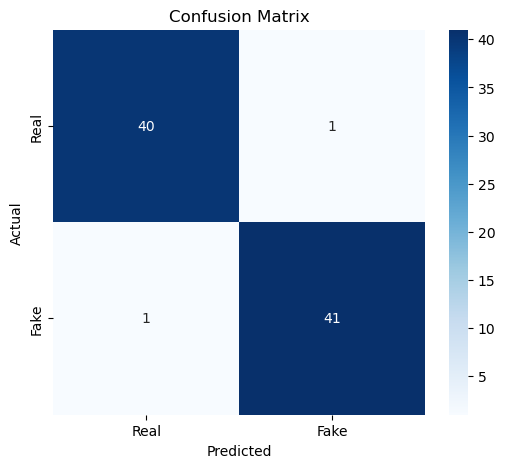

In [7]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Testing

In [10]:
def predict_single(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    label = "REAL" if pred.item() == 0 else "FAKE"
    return label, conf.item(), img  # also return image for display

def show_prediction(image_path):
    label, conf, raw_img = predict_single(image_path)
    plt.figure(figsize=(4,4))
    plt.imshow(raw_img)
    plt.axis("off")
    plt.title(f"Prediction: {label} (conf: {conf:.2f})")
    plt.show()


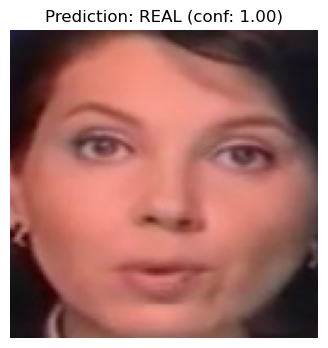

In [11]:
show_prediction("test_images/real/029_frame385.jpg")

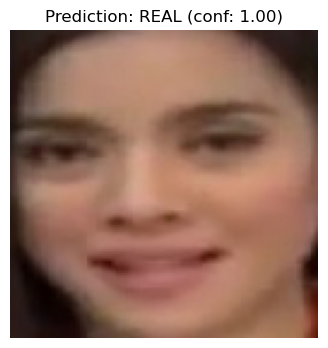

In [13]:
show_prediction("test_images/real/012_frame25.jpg")


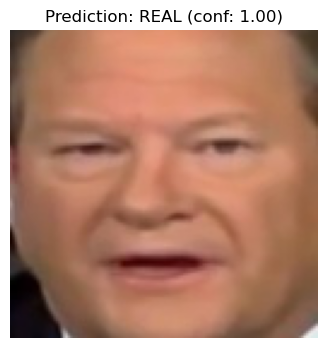

In [14]:
show_prediction("test_images/real/009_frame251.jpg")

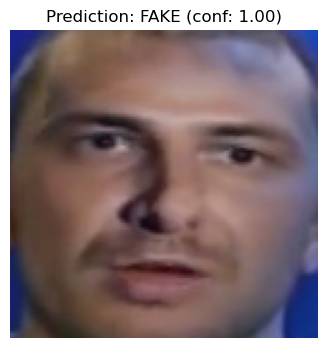

In [15]:
show_prediction("test_images/fake/777_745_frame92.jpg")

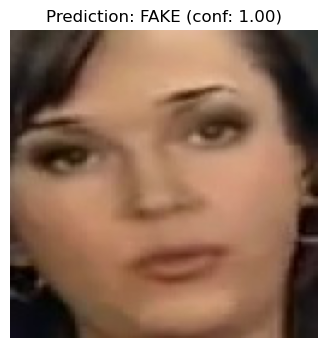

In [16]:
show_prediction("test_images/fake/992_980_frame563.jpg")

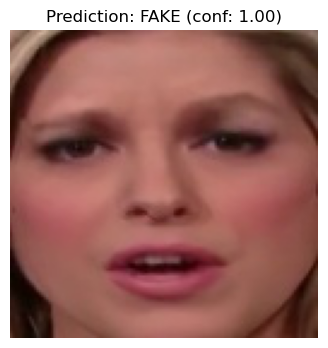

In [17]:
show_prediction("test_images/fake/998_561_frame29.jpg")

Loss and Accuracy curve 

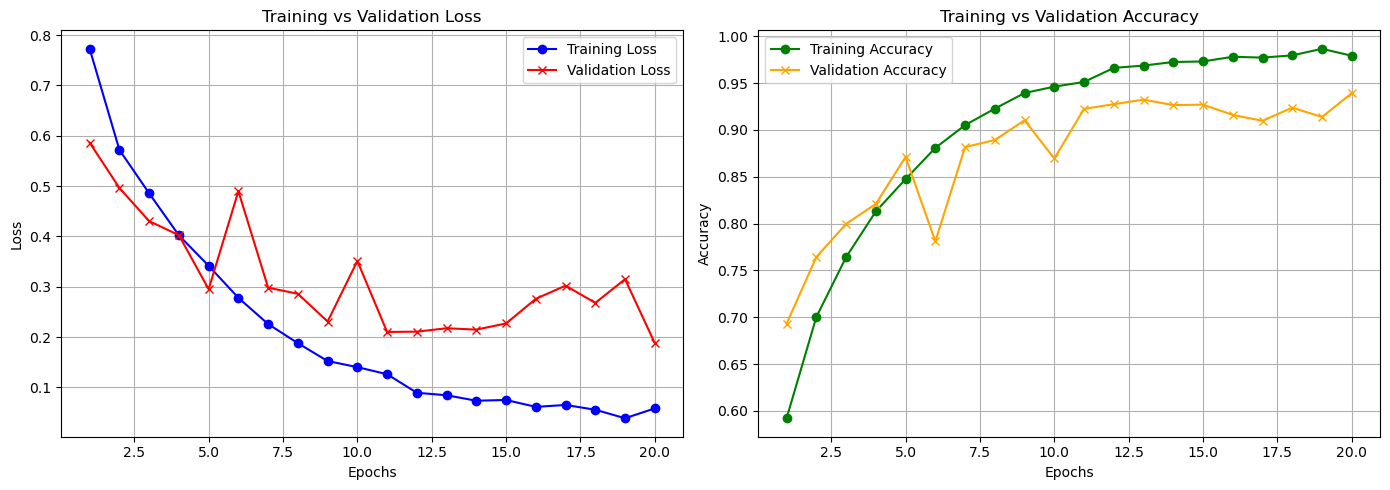

In [18]:
import matplotlib.pyplot as plt

# --- 1. DATA (Extracted from your logs) ---
epochs = list(range(1, 21))

train_loss = [0.7727, 0.5719, 0.4856, 0.4021, 0.3416, 0.2779, 0.2259, 0.1878, 0.1524, 0.1402, 
              0.1262, 0.0893, 0.0844, 0.0735, 0.0750, 0.0613, 0.0651, 0.0556, 0.0387, 0.0583]

val_loss = [0.5862, 0.4962, 0.4304, 0.4024, 0.2951, 0.4898, 0.2981, 0.2860, 0.2309, 0.3511, 
            0.2102, 0.2107, 0.2175, 0.2148, 0.2270, 0.2760, 0.3021, 0.2679, 0.3150, 0.1879]

train_acc = [0.5922, 0.7003, 0.7641, 0.8130, 0.8475, 0.8808, 0.9051, 0.9227, 0.9394, 0.9462, 
             0.9512, 0.9662, 0.9687, 0.9725, 0.9731, 0.9781, 0.9772, 0.9796, 0.9866, 0.9792]

val_acc = [0.6932, 0.7643, 0.7997, 0.8210, 0.8712, 0.7810, 0.8817, 0.8892, 0.9103, 0.8695, 
           0.9225, 0.9275, 0.9323, 0.9265, 0.9270, 0.9160, 0.9097, 0.9238, 0.9138, 0.9392]

# --- 2. PLOTTING ---
plt.figure(figsize=(14, 5))

# Plot 1: Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', color='green')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='x', color='orange')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()